In [2]:
import os
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
image_size = 64
batch_size = 64

In [7]:
transform = tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
#     tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

path = '/kaggle/input/'
image_folder = ImageFolder(path, transform=transform)

data_loader = DataLoader(image_folder, batch_size=batch_size, shuffle=True)

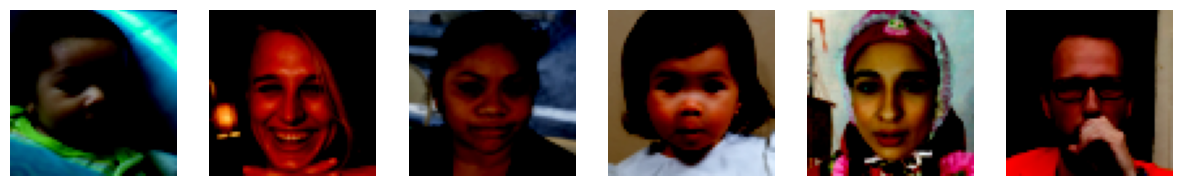

In [8]:
n = 6
fig, ax = plt.subplots(ncols=n, figsize=(15, 4))
for i in range(n):
    image = image_folder[i][0].permute(1, 2, 0)
    ax[i].imshow(image)
    ax[i].axis(False)
plt.show()

In [9]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [10]:
latent_size = 128

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
def fit(model, opt, loss_func, epochs, data_loader):
    model['discriminator'].train()
    model['generator'].train()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in tqdm(range(epochs)):
        _losses_d = []
        _losses_g = []
        for x, _ in tqdm(data_loader, desc=f'Epoch: {epoch+1}'):
            x = x.to(device)
            real_labels = torch.FloatTensor(x.shape[0], 1).uniform_(0.95, 1.0).to(device)
            fake_labels = torch.FloatTensor(x.shape[0], 1).uniform_(0.0, 0.05).to(device)
            z = torch.randn(x.shape[0], latent_size, 1, 1, device=device)
            
            # learning discriminator
            opt['discriminator'].zero_grad()
            outputs_real = model['discriminator'](x)

            d_loss_real = loss_func['discriminator'](outputs_real, real_labels)
            real_score = torch.mean(outputs_real).item()    
            
            x_hat = model['generator'](z)
            outputs_fake = model['discriminator'](x_hat.detach())
            d_loss_fake = loss_func['discriminator'](outputs_fake, fake_labels)
            fake_score = torch.mean(outputs_fake).item()

            loss_d = d_loss_real + d_loss_fake
            loss_d.backward()
            opt['discriminator'].step()
            _losses_d.append(loss_d.item())

            # learning generator
            opt['generator'].zero_grad()
            x_hat = model['generator'](z)
            outputs_fake = model['discriminator'](x_hat)
            loss_g = loss_func['generator'](outputs_fake, real_labels)

            loss_g.backward()
            opt['generator'].step()
            _losses_g.append(loss_g.item())
            
        losses_g.append(np.mean(_losses_g))
        losses_d.append(np.mean(_losses_d))
        real_scores.append(np.mean(real_score))
        fake_scores.append(np.mean(fake_score))
        
        print(f'losses_g = {round(losses_g[-1], 5)},   losses_d = {round(losses_d[-1], 5)}')
        print(f'real_scores = {round(real_scores[-1], 5)},   fake_scores = {round(fake_scores[-1], 5)}')
        n = 4
        fig, ax = plt.subplots(ncols=n, figsize=(10, 4))
        z = torch.randn(n, latent_size, 1, 1, device=device)
        x_hat = model['generator'](z)
        for i in range(4):
            img = x_hat[i].permute(1, 2, 0).cpu().detach().numpy()
            ax[i].imshow(img)
            ax[i].axis(False)
        plt.show()
        
    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 6.33025,   losses_d = 0.33735
real_scores = 0.95135,   fake_scores = 0.0226


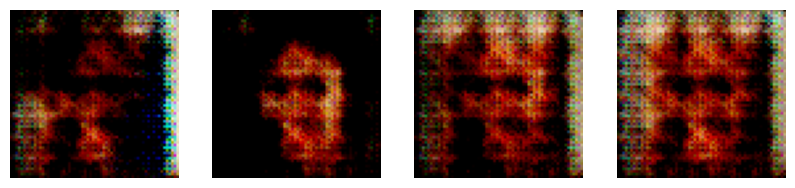

Epoch: 2:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.64953,   losses_d = 0.31185
real_scores = 0.94729,   fake_scores = 0.02103


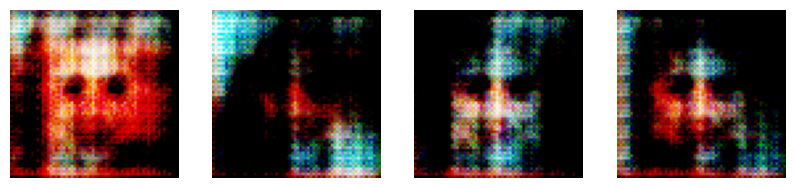

Epoch: 3:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.53898,   losses_d = 0.30838
real_scores = 0.98213,   fake_scores = 0.0466


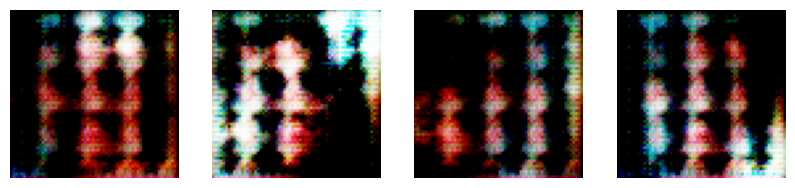

Epoch: 4:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.40456,   losses_d = 0.30028
real_scores = 0.97728,   fake_scores = 0.02974


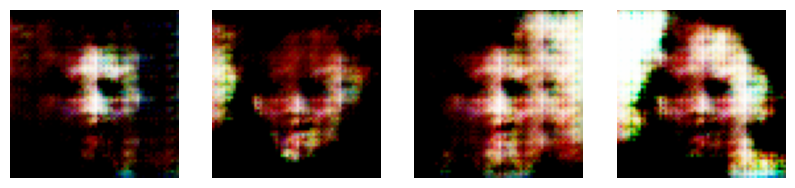

Epoch: 5:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.41513,   losses_d = 0.30009
real_scores = 0.95342,   fake_scores = 0.0173


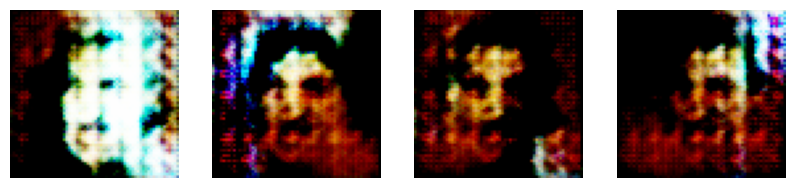

Epoch: 6:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.44017,   losses_d = 0.30206
real_scores = 0.94158,   fake_scores = 0.07619


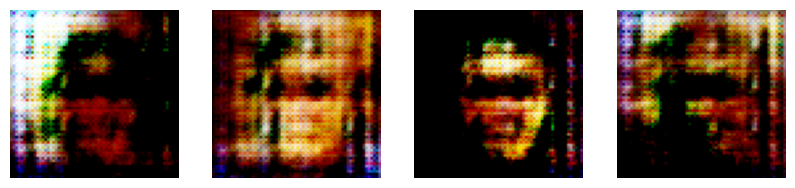

Epoch: 7:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.46684,   losses_d = 0.29561
real_scores = 0.84526,   fake_scores = 0.01863


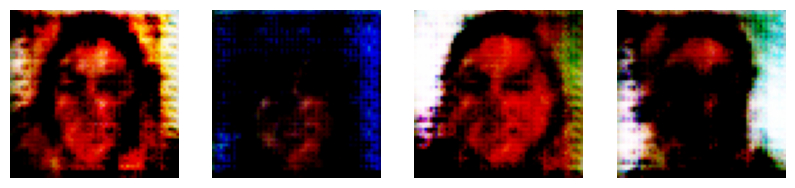

Epoch: 8:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.39196,   losses_d = 0.30445
real_scores = 0.82623,   fake_scores = 0.01031


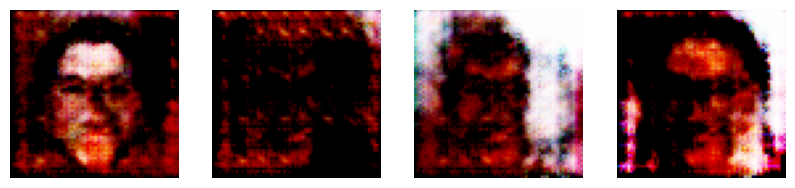

Epoch: 9:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.43461,   losses_d = 0.30158
real_scores = 0.94052,   fake_scores = 0.0172


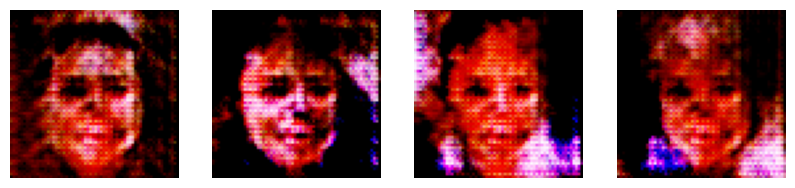

Epoch: 10:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.40606,   losses_d = 0.30699
real_scores = 0.89871,   fake_scores = 0.06222


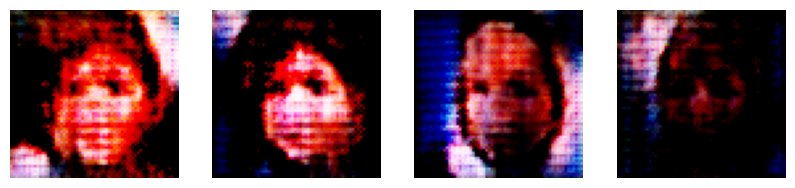

Epoch: 11:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.34015,   losses_d = 0.31093
real_scores = 0.97227,   fake_scores = 0.05638


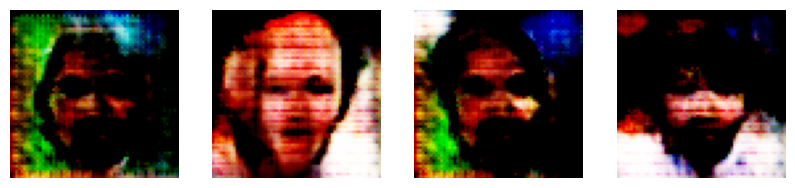

Epoch: 12:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.29913,   losses_d = 0.31575
real_scores = 0.97516,   fake_scores = 0.09871


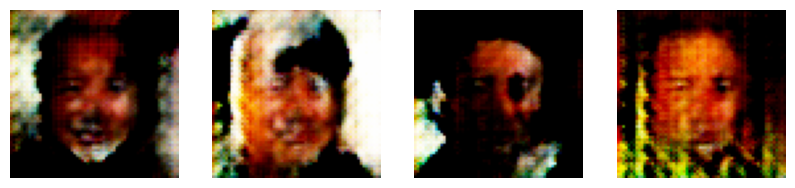

Epoch: 13:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.36439,   losses_d = 0.31338
real_scores = 0.89962,   fake_scores = 0.04991


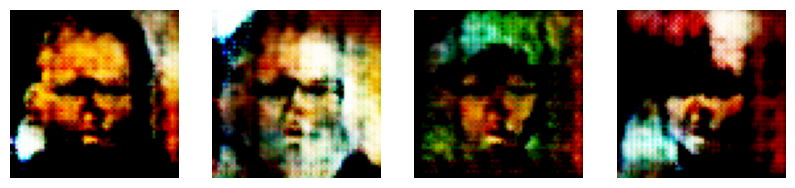

Epoch: 14:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.27206,   losses_d = 0.31795
real_scores = 0.91483,   fake_scores = 0.14825


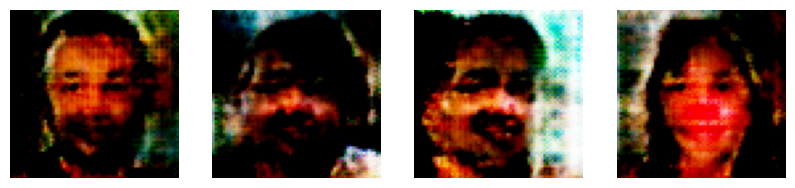

Epoch: 15:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.21017,   losses_d = 0.30369
real_scores = 0.91878,   fake_scores = 0.01481


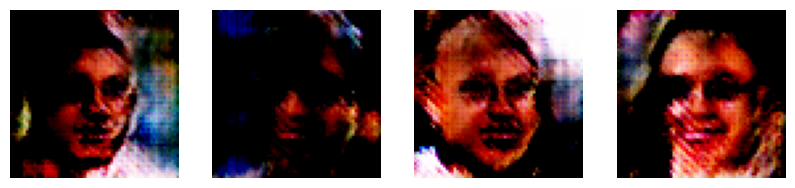

Epoch: 16:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.22415,   losses_d = 0.2993
real_scores = 0.98222,   fake_scores = 0.05327


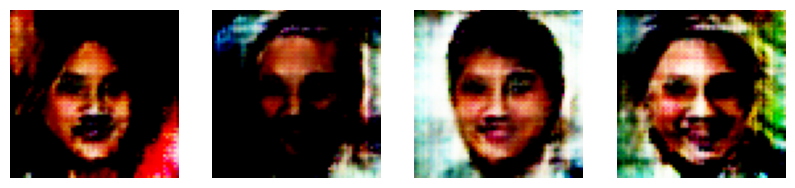

Epoch: 17:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.24649,   losses_d = 0.30799
real_scores = 0.99534,   fake_scores = 0.06566


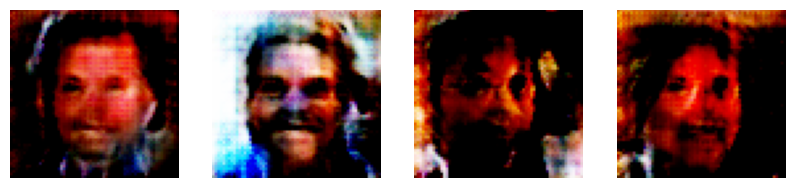

Epoch: 18:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.2481,   losses_d = 0.30795
real_scores = 0.87852,   fake_scores = 0.06544


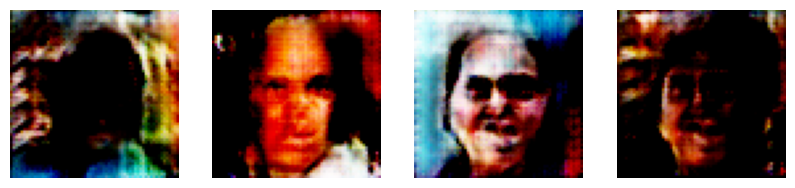

Epoch: 19:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.26543,   losses_d = 0.3149
real_scores = 0.90672,   fake_scores = 0.01523


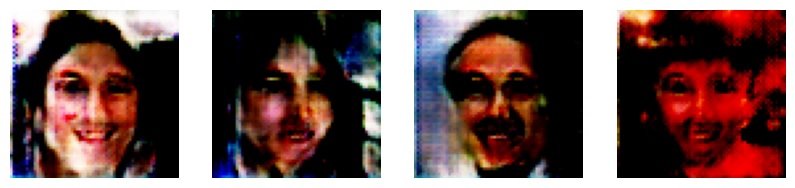

Epoch: 20:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.18818,   losses_d = 0.31126
real_scores = 0.96326,   fake_scores = 0.03031


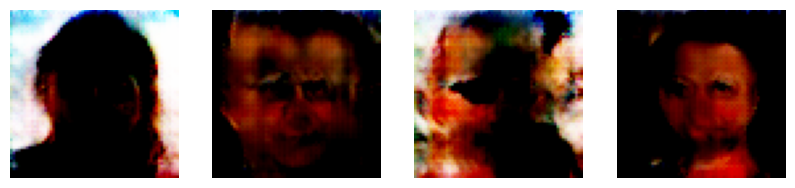

Epoch: 21:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.20297,   losses_d = 0.31803
real_scores = 0.94845,   fake_scores = 0.03026


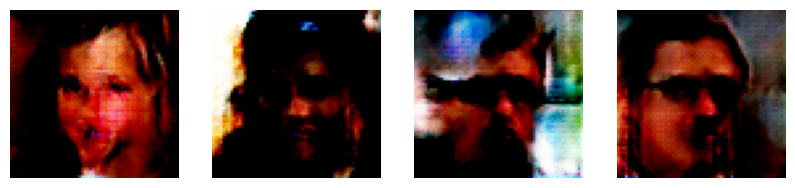

Epoch: 22:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.13317,   losses_d = 0.31825
real_scores = 0.95475,   fake_scores = 0.02919


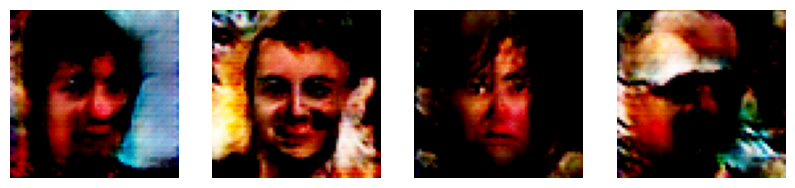

Epoch: 23:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.18358,   losses_d = 0.31546
real_scores = 0.98434,   fake_scores = 0.07535


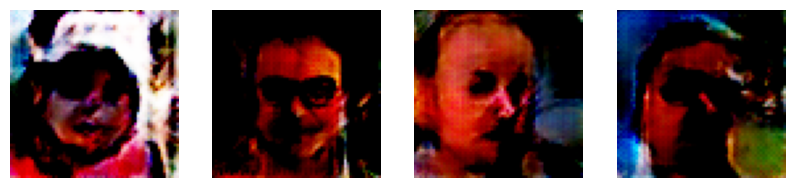

Epoch: 24:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.13122,   losses_d = 0.32655
real_scores = 0.86934,   fake_scores = 0.0324


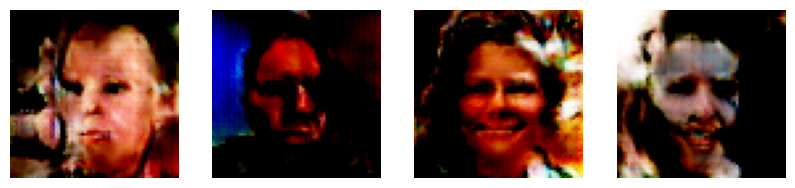

Epoch: 25:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.09716,   losses_d = 0.32733
real_scores = 0.93895,   fake_scores = 0.07009


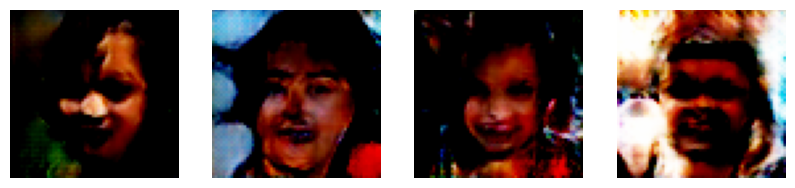

Epoch: 26:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.08661,   losses_d = 0.32228
real_scores = 0.88467,   fake_scores = 0.06236


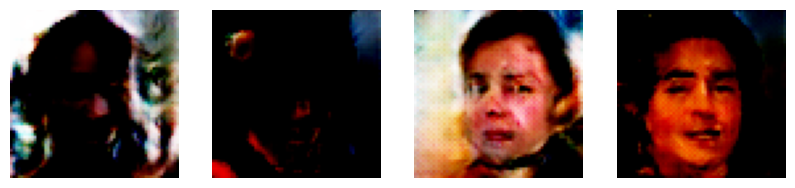

Epoch: 27:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.10074,   losses_d = 0.3282
real_scores = 0.92274,   fake_scores = 0.00664


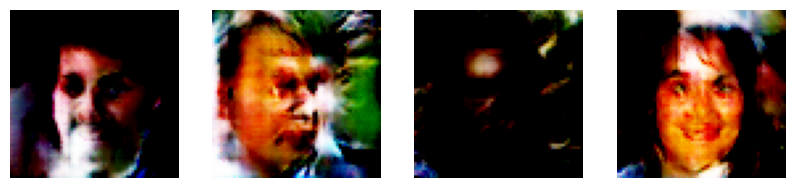

Epoch: 28:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.15513,   losses_d = 0.34018
real_scores = 0.96843,   fake_scores = 0.00356


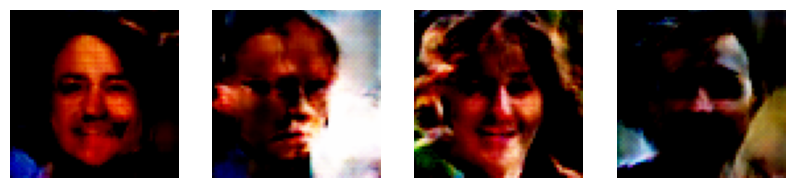

Epoch: 29:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.00059,   losses_d = 0.33748
real_scores = 0.97889,   fake_scores = 0.01489


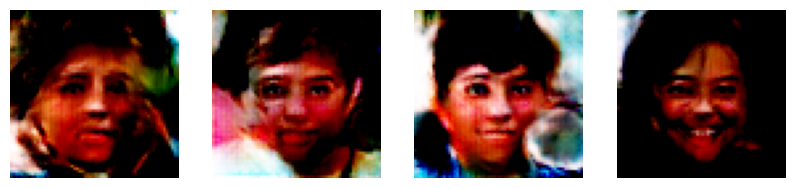

Epoch: 30:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 3.98286,   losses_d = 0.33131
real_scores = 0.94444,   fake_scores = 0.02153


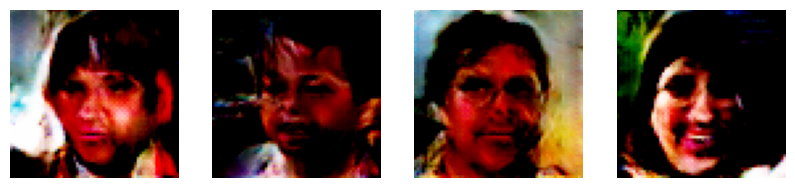

Epoch: 31:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.04804,   losses_d = 0.34254
real_scores = 0.9575,   fake_scores = 0.15146


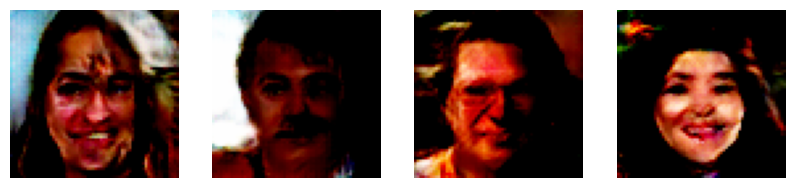

Epoch: 32:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 3.95451,   losses_d = 0.3293
real_scores = 0.91223,   fake_scores = 0.02876


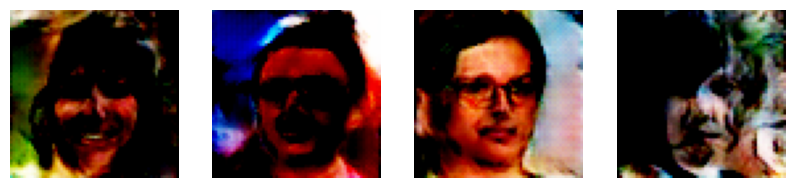

Epoch: 33:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 4.03338,   losses_d = 0.3556
real_scores = 0.9598,   fake_scores = 0.06461


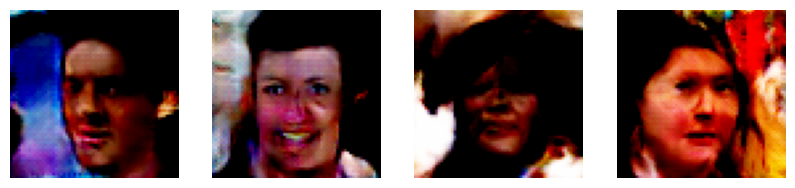

Epoch: 34:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 3.88859,   losses_d = 0.3435
real_scores = 0.97074,   fake_scores = 0.10175


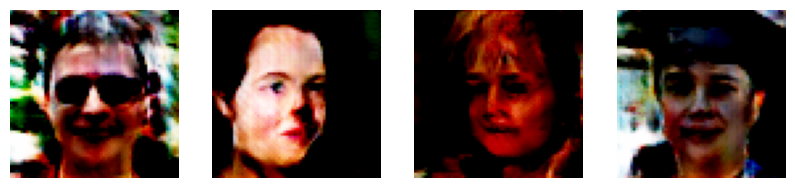

Epoch: 35:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 3.96259,   losses_d = 0.35383
real_scores = 0.83046,   fake_scores = 0.04078


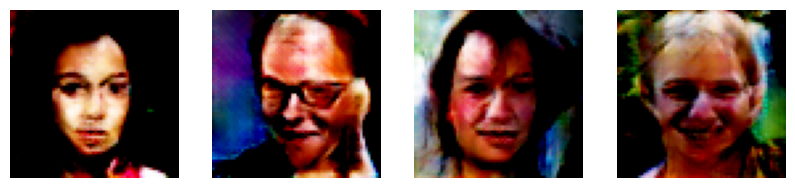

Epoch: 36:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 3.97436,   losses_d = 0.34625
real_scores = 0.83278,   fake_scores = 0.03


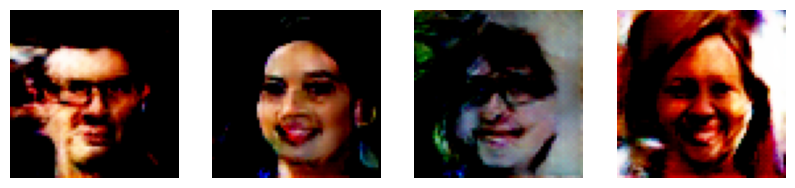

Epoch: 37:   0%|          | 0/813 [00:00<?, ?it/s]

losses_g = 3.90221,   losses_d = 0.34257
real_scores = 0.9346,   fake_scores = 0.03546


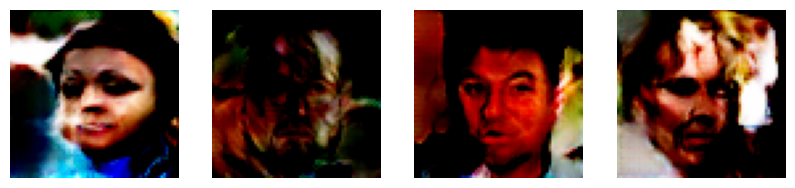

Epoch: 38:   0%|          | 0/813 [00:00<?, ?it/s]

In [ ]:
model = {
    'discriminator': discriminator,
    'generator': generator
}
model['discriminator'].apply(weights_init)
model['generator'].apply(weights_init)

model['discriminator'].to(device)
model['generator'].to(device)

loss_func = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}
lr = 0.0002
opt = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr = lr),
    'generator': torch.optim.Adam(model['generator'].parameters(), lr = lr)
}

epochs = 50
losses_g, losses_d, real_scores, fake_scores = fit(model, opt, loss_func, epochs, data_loader)